In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import cv2

from lib.opts import opts
from lib.detectors.detector_factory import detector_factory
from lib.detectors.my_detector import MyDetector

import glob
import numpy as np
from tqdm import tqdm
import torch

2.4.1+cu121


In [2]:
from PIL import Image
import depth_pro
import time
import matplotlib.pyplot as plt


In [3]:
import sys
sys.argv = [
    "program_name",
    "--load_model", 
    "/home/CenterPose/exp/object_pose/objectron_custom_box_dlav1_34_2024-10-23-06-05/custom_box_best.pth"
]

In [4]:
parser = opts().parser
opt = parser.parse_args()

# Default setting
opt.nms = True
opt.obj_scale = True
# opt.obj_scale = False


# PnP related
meta = {}
if opt.cam_intrinsic is None:
    meta['camera_matrix'] = np.array(
        [[663.0287679036459, 0, 300.2775065104167], [0, 663.0287679036459, 395.00066121419275], [0, 0, 1]])
    opt.cam_intrinsic = meta['camera_matrix']
else:
    meta['camera_matrix'] = np.array(opt.cam_intrinsic).reshape(3, 3)

# Update default configurations
opt = opts().parse(opt)

# Update dataset info/training params
opt = opts().init(opt)

opt.c = 'custom_box'
opt.arch = 'dlav1_34'

Fix size testing.
training chunk_sizes: [1]
The output will be saved to  /home/CenterPose/src/lib/../../exp/object_pose/default
heads {'hm': 1, 'wh': 2, 'hps': 16, 'reg': 2, 'hm_hp': 8, 'hp_offset': 2, 'scale': 3}


In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = opt.gpus_str
opt.debug = max(opt.debug, 1)
# Detector = detector_factory[opt.task]
print("opt.arch: ", opt.arch)
detector = MyDetector(opt)
print("model loaded")
if opt.use_pnp == True and 'camera_matrix' not in meta.keys():
    raise RuntimeError('Error found. Please give the camera matrix when using pnp algorithm!')


opt.arch:  dlav1_34
Creating model...


loaded /home/CenterPose/exp/object_pose/objectron_custom_box_dlav1_34_2024-10-23-06-05/custom_box_best.pth, epoch 90
model loaded


In [6]:
def resize_with_padding(image, target_size=512):
    # Get original dimensions
    h, w = image.shape[:2]
    
    # Calculate aspect ratio
    aspect = w/h
    
    # Calculate new dimensions maintaining aspect ratio
    if aspect > 1:  # width > height
        new_w = target_size
        new_h = int(target_size/aspect)
    else:  # height > width
        new_h = target_size
        new_w = int(target_size*aspect)
        
    # Resize image
    resized = cv2.resize(image, (new_w, new_h))
    
    # Create empty canvas
    if resized.ndim == 2:
        padded = np.zeros((target_size, target_size), dtype=np.uint8)
    else:
        padded = np.zeros((target_size, target_size, 3), dtype=np.uint8)
    
    # Calculate padding
    pad_h = (target_size - new_h) // 2
    pad_w = (target_size - new_w) // 2
    
    # Place resized image in center
    padded[pad_h:pad_h+new_h, pad_w:pad_w+new_w] = resized
    
    return padded

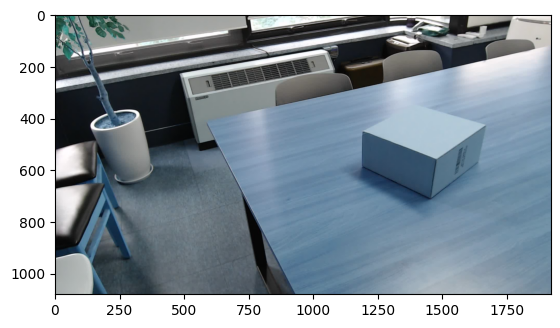

In [7]:
image_name = "/home/custom_dataset/box_folders/box_barcode_1/0001.jpg"
image = np.array(cv2.imread(image_name))
# padded_image = resize_with_padding(image)
# print(padded_image.shape)
# plt.imshow(padded_image)
plt.imshow(image)


In [12]:
dets, img_dict = detector.run(image, meta_inp=meta)
dets.keys()

dict_keys(['bboxes', 'scores', 'kps', 'clses', 'obj_scale', 'obj_scale_uncertainty', 'tracking', 'tracking_hp', 'kps_displacement_mean', 'kps_displacement_std', 'kps_heatmap_mean', 'kps_heatmap_std', 'kps_heatmap_height'])

In [13]:
i=0
for k in range(len(dets['scores'][i])):
    if dets['scores'][i][k][0] > opt.center_thresh:
        print(k)
        print(dets['kps'][i][k].shape)
        print(dets['kps'][i][k])    
        

0
(16,)
[314.53668 232.24094 388.03955 259.98172 384.01047 299.96957 318.20193
 265.3026  367.94247 203.96619 437.9384  222.89384 435.99667 264.00406
 371.98773 235.98343]


In [47]:
def drawLine(image, kps, color=(255, 0, 0), thickness=7):
    new_image = image.copy()
    # edges = [
    #             [1, 2], [2, 3], [3, 4], [4, 1],  # 윗면
    #             [5, 6], [6, 7], [7, 8], [8, 5],  # 아랫면
    #             [1, 5], [2, 6], [3, 7], [4, 8]   # 수직 모서리
    #         ]

    points = np.array(kps, dtype=np.int32).reshape(8, 2)
    points[:, 0] = points[:, 0] * 1920 / 512
    
    normalized_height = (512 * 1080 / 1920)
    padding = (512 - normalized_height) / 2
    points[:, 1] = (points[:, 1] - padding) * 1080 / normalized_height 

    # Draw corner points
    plt.scatter(points[:, 0], points[:, 1], color='red', s=thickness)
    colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'white']
    for idx, point in enumerate(points):
        plt.scatter(point[0], point[1], color=colors[idx], s=thickness)
        plt.text(point[0], point[1], str(idx), color=colors[idx], fontsize=12)


    # Draw edges
    # for j, e in enumerate(edges):
        
    #     temp = [e[0] - 1, e[1] - 1]
    #     edge_color = (255, 0, 0)  # bgr
    #     if points[temp[1], 0] <= -10000 or points[temp[1], 1] <= -10000 or points[temp[0], 0] <= -10000 or \
    #             points[temp[0], 1] <= -10000:
    #         continue
    #     else:
    #         start_point = (int(points[temp[0], 0]), int(points[temp[0], 1]))
    #         end_point = (int(points[temp[1], 0]), int(points[temp[1], 1]))
    #         cv2.line(new_image, start_point, end_point, edge_color, 2)
            
    plt.imshow(new_image)
    return points

image shape:  (1080, 1920, 3)


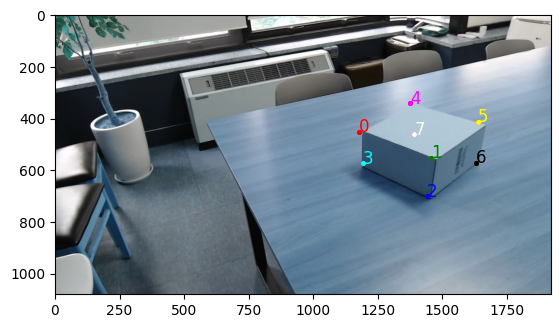

In [48]:
print('image shape: ', image.shape)
_ = drawLine(image, dets['kps'][0][0])

In [26]:
model_depthpro, transform_depthpro = depth_pro.create_model_and_transforms()
model_depthpro.eval()

/home/ml-depth-pro/src/depth_pro/depth_pro.py:137: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(config.checkpoint_uri, map_location=device)
/home/ml

Checkpoint not found at ./checkpoints/depth_pro.pt.
loading /home/ml-depth-pro/checkpoints/depth_pro.pt ...


DepthPro(
  (encoder): DepthProEncoder(
    (patch_encoder): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linea

depth shape:  (1080, 1920)


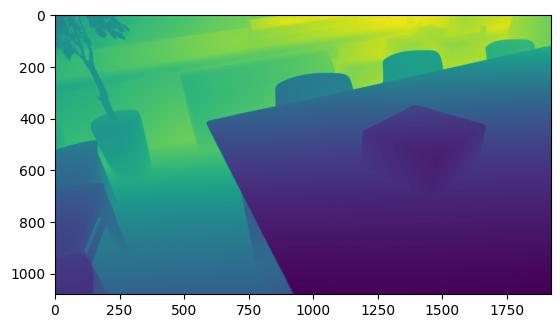

In [38]:
image_depthpro, _, f_px = depth_pro.load_rgb(image_name)
image_transform = transform_depthpro(image_depthpro)
prediction = model_depthpro.infer(image_transform, f_px=f_px)
depth = prediction["depth"]  # Depth in [m].
depth = depth.cpu().numpy()
plt.imshow(depth)
print("depth shape: ", depth.shape)


(8, 2)

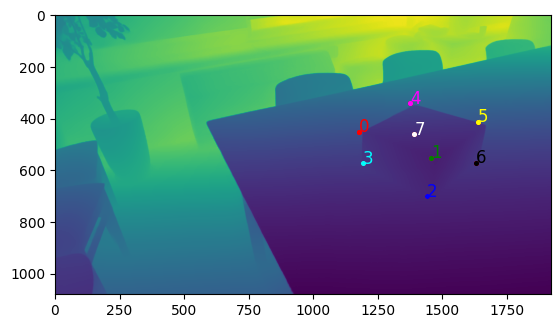

In [49]:
kps = drawLine(depth, dets['kps'][0][0])
kps.shape

In [68]:
# Calculate the 1:22 internal division point between the 2nd and 3rd points in kps
point_2 = kps[2]
point_3 = kps[3]

# Calculate the internal division point
inter_div_point = (1 * point_3 + 1 * point_2) / (1 + 1)
inter_div_point = inter_div_point.astype(int)

# Calculate the external division point
ext_div_point = (2 * point_3 - 1 * point_2) / (2 - 1)
ext_div_point = ext_div_point.astype(int)

print("2:1 external division point:", ext_div_point)

print("1:1 internal division point:", inter_div_point)

2:1 external division point: [944 445]
1:1 internal division point: [1316  637]


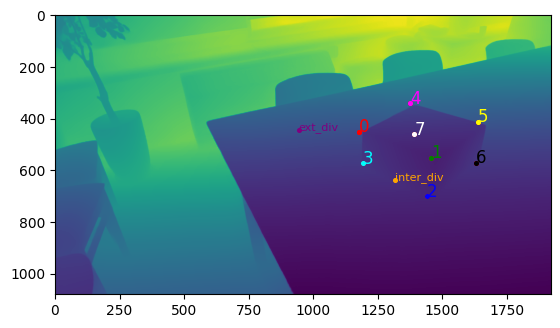

In [69]:
new_image = depth.copy()
# edges = [
#             [1, 2], [2, 3], [3, 4], [4, 1],  # 윗면
#             [5, 6], [6, 7], [7, 8], [8, 5],  # 아랫면
#             [1, 5], [2, 6], [3, 7], [4, 8]   # 수직 모서리
#         ]

# Draw corner points
plt.scatter(kps[:, 0], kps[:, 1], color='red', s=7)
colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'white']
for idx, point in enumerate(kps):
    plt.scatter(point[0], point[1], color=colors[idx], s=7)
    plt.text(point[0], point[1], str(idx), color=colors[idx], fontsize=12)

plt.scatter(inter_div_point[0], inter_div_point[1], color='orange', s=7)
plt.text(inter_div_point[0], inter_div_point[1], "inter_div", color='orange', fontsize=8)

plt.scatter(ext_div_point[0], ext_div_point[1], color='purple', s=7)
plt.text(ext_div_point[0], ext_div_point[1], "ext_div", color='purple', fontsize=8)

plt.imshow(new_image)

In [73]:
edge_pixel_diff = np.linalg.norm(kps[2] - kps[3])
edge_depth_diff = abs(depth[kps[2][1], kps[2][0]] - depth[kps[3][1], kps[3][0]])

criteria_pixel_diff = np.linalg.norm(kps[2] - inter_div_point)
criteria_depth_diff = abs(depth[kps[2][1], kps[2][0]] - depth[inter_div_point[1], inter_div_point[0]])
edge_length = 11.5 / criteria_depth_diff * edge_depth_diff
print("edge_length(int): ", edge_length)
print("criteria_depth_diff: ",criteria_depth_diff)
criteria_pixel_diff = np.linalg.norm(kps[2] - ext_div_point)
criteria_depth_diff = abs(depth[kps[2][1], kps[2][0]] - depth[ext_div_point[1], ext_div_point[0]])
edge_length = 46 / criteria_depth_diff * edge_depth_diff
print("edge_length(ext): ", edge_length)
print("criteria_depth_diff: ",criteria_depth_diff)


edge_length(int):  24.80331942441475
criteria_depth_diff:  0.071336865
edge_length(ext):  16.197247083203518
criteria_depth_diff:  0.43696094


In [74]:
print("2~3 :", abs(depth[kps[2][1], kps[2][0]] - depth[kps[3][1], kps[3][0]]))
print("5~4 :", abs(depth[kps[5][1], kps[5][0]] - depth[kps[4][1], kps[4][0]]))


2~3 : 0.15386009
5~4 : 0.19748032


In [79]:
# Calculate the 1:22 internal division point between the 2nd and 3rd points in kps
point_2 = kps[2]
point_6 = kps[6]

# Calculate the internal division point
inter_div_point = (1 * point_6 + 1 * point_2) / (1 + 1)
inter_div_point = inter_div_point.astype(int)

# Calculate the external division point
ext_div_point = (2 * point_6 - 1 * point_2) / (2 - 1)
ext_div_point = ext_div_point.astype(int)

print("2:1 external division point:", ext_div_point)

print("1:1 internal division point:", inter_div_point)

2:1 external division point: [1822  439]
1:1 internal division point: [1535  635]


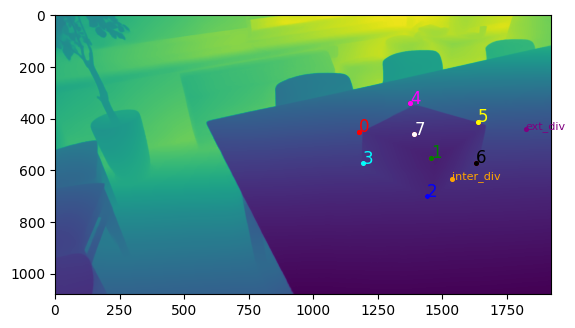

In [80]:
new_image = depth.copy()

# Draw corner points
plt.scatter(kps[:, 0], kps[:, 1], color='red', s=7)
colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'white']
for idx, point in enumerate(kps):
    plt.scatter(point[0], point[1], color=colors[idx], s=7)
    plt.text(point[0], point[1], str(idx), color=colors[idx], fontsize=12)

plt.scatter(inter_div_point[0], inter_div_point[1], color='orange', s=7)
plt.text(inter_div_point[0], inter_div_point[1], "inter_div", color='orange', fontsize=8)

plt.scatter(ext_div_point[0], ext_div_point[1], color='purple', s=7)
plt.text(ext_div_point[0], ext_div_point[1], "ext_div", color='purple', fontsize=8)

plt.imshow(new_image)

In [81]:
edge_pixel_diff = np.linalg.norm(kps[2] - kps[6])
edge_depth_diff = abs(depth[kps[2][1], kps[2][0]] - depth[kps[6][1], kps[6][0]])

criteria_pixel_diff = np.linalg.norm(kps[2] - inter_div_point)
criteria_depth_diff = abs(depth[kps[2][1], kps[2][0]] - depth[inter_div_point[1], inter_div_point[0]])
edge_length = 13 / criteria_depth_diff * edge_depth_diff
print("edge_length(int): ", edge_length)
print("criteria_depth_diff: ",criteria_depth_diff)
criteria_pixel_diff = np.linalg.norm(kps[2] - ext_div_point)
criteria_depth_diff = abs(depth[kps[2][1], kps[2][0]] - depth[ext_div_point[1], ext_div_point[0]])
edge_length = 52 / criteria_depth_diff * edge_depth_diff
print("edge_length(ext): ", edge_length)
print("criteria_depth_diff: ",criteria_depth_diff)

edge_length(int):  36.36437853416819
criteria_depth_diff:  0.056582928
edge_length(ext):  20.98944047980242
criteria_depth_diff:  0.39212155
